In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from random import sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller,acf
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
funnel=pd.read_excel("Intern Hiring Assignment Data.xlsx",sheet_name="Funnel")
funnel

,Year,Month,Customer Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,1354648.0
1,2020,12,Clients,India,Lv2_Visitors,Actuals,2689569.0
2,2020,12,Clients,India,Lv3_Visitors,Actuals,1300571.0
3,2020,12,Clients,India,Lv4_Visitors,Actuals,NaN
4,2020,12,Clients,India,Lv3_Visitors,Actuals,706677.0
...,...,...,...,...,...,...,...
1567,2022,1,Customers,Dehradun,Lv5_Visitors,Actuals,1693.0
1568,2022,1,Customers,Aurangabad,Lv4_Visitors,Actuals,1428.0
1569,2022,1,Customers,Ujjain,Lv5_Visitors,Actuals,1311.0
1570,2022,1,Customers,Faridabad,Lv5_Visitors,Actuals,1071.0


In [4]:
funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              1572 non-null   int64  
 1   Month             1572 non-null   int64  
 2   Customer Segment  1572 non-null   object 
 3   Region            1572 non-null   object 
 4   KPI               1572 non-null   object 
 5   Value Type        1572 non-null   object 
 6   Value             1547 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 86.1+ KB


In [5]:
funnel.value_counts()

Year  Month  Customer Segment  Region     KPI           Value Type  Value    
2020  1      Clients           India      Lv1_Visitors  Actuals     3322789.0    1
2022  4      Clients           Indore     Lv2_Visitors  Actuals     63090.0      1
      3      Customers         India      Lv1_Visitors  Actuals     578083.0     1
                               Faridabad  Lv5_Visitors  Actuals     1524.0       1
                                          Lv4_Visitors  Actuals     5967.0       1
                                                                                ..
2021  2      Customers         Uddepy     Lv4_Visitors  Actuals     42753.0      1
                                          Lv3_Visitors  Actuals     88016.0      1
                                          Lv2_Visitors  Actuals     87365.0      1
                                          Lv1_Visitors  Actuals     114704.0     1
2022  12     Customers         Ujjain     Lv5_Visitors  Actuals     293.0        1
Name: cou

In [6]:
funnel.drop(columns=["Value Type"],inplace=True)

In [7]:
pd.options.display.float_format = '{:.2f}'.format

In [8]:
# Convert 'Year' and 'Month' to datetime
funnel['date'] = pd.to_datetime(funnel[['Year', 'Month']].assign(day=1))

# Sort by 'date'
funnel.sort_values('date', inplace=True)

,Year,Month,Customer Segment,Region,KPI,Value,date
Year,1.00,0.00,-0.23,0.09,-0.02,-0.05,0.95
Month,0.00,1.00,-0.00,0.00,0.00,-0.02,0.33
Customer Segment,-0.23,-0.00,1.00,-0.16,-0.05,-0.59,-0.22
Region,0.09,0.00,-0.16,1.00,-0.00,0.26,0.09
KPI,-0.02,0.00,-0.05,-0.00,1.00,-0.36,-0.02
Value,-0.05,-0.02,-0.59,0.26,-0.36,1.00,-0.05
date,0.95,0.33,-0.22,0.09,-0.02,-0.05,1.00


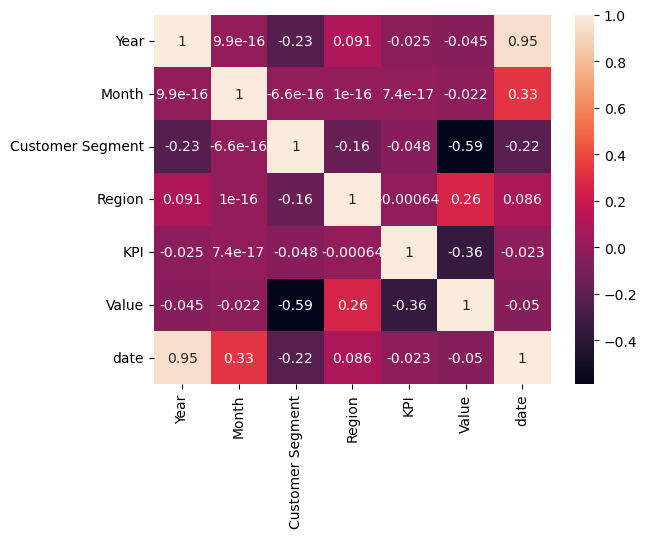

In [9]:
# Create a copy of the DataFrame
df_encoded = funnel.copy()

# Apply LabelEncoder to each column
for column in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Now you can create your heatmap
sns.heatmap(df_encoded.corr(), annot=True)
df_encoded.corr()

In [10]:
for kpi in funnel['KPI'].unique():
    mean = funnel[funnel['KPI'] == kpi]['Value'].mean()
    median = funnel[funnel['KPI'] == kpi]['Value'].median()
    print(f"For KPI {kpi}, Mean: {mean}, Median: {median}")

For KPI Lv1_Visitors, Mean: 544273.1833333333, Median: 78694.5
For KPI Lv5_Visitors, Mean: 43758.41358024691, Median: 7757.0
For KPI Lv4_Visitors, Mean: 127959.91693290735, Median: 26418.0
For KPI Lv2_Visitors, Mean: 367219.31740614335, Median: 51787.0
For KPI Lv3_Visitors, Mean: 285153.8264984227, Median: 50636.0


In [11]:
# train_data = funnel[funnel['Value'].notnull()]
# predict_data = funnel[funnel['Value'].isnull()]

# X_train, X_val, y_train, y_val = train_test_split(train_data.drop('Value', axis=1), 
#                                                   train_data['Value'], 
#                                                   test_size=0.2, 
#                                                   random_state=42)

# train_pool = Pool(data=X_train, label=y_train, cat_features=["Customer Segment","Region","Value Type"])
# val_pool = Pool(data=X_val, label=y_val, cat_features=["Customer Segment","Region","Value Type"])

# model = CatBoostRegressor()

# grid = {'iterations': [100, 200, 300],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'depth': [4, 6, 8],
#         'l2_leaf_reg': [1, 3, 5]}

# result = model.grid_search(grid, train_pool, plot=True, verbose=False)

# print(result['params'])
# print(min(result['cv_results']['test-RMSE-mean']))

In [11]:
# Split the data
train_data = funnel[funnel['Value'].notnull()]
predict_data = funnel[funnel['Value'].isnull()]

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('Value', axis=1), 
                                                  train_data['Value'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# Create Pool objects for train and validation sets
train_pool = Pool(data=X_train, label=y_train, cat_features=["Customer Segment","Region","KPI"])
val_pool = Pool(data=X_val, label=y_val, cat_features=["Customer Segment","Region","KPI"])

#Best Params
best_params={'depth': 6, 'l2_leaf_reg': 2, 'iterations': 600, 'learning_rate': 0.05}

# Initialize the model
model = CatBoostRegressor(**best_params)

# Fit the model with the best parameters
model.fit(train_pool)

# Predict the missing values
predict_data['Value'] = model.predict(predict_data.drop('Value', axis=1))

0:	learn: 622534.5062402	total: 173ms	remaining: 1m 43s
1:	learn: 601428.9667503	total: 201ms	remaining: 1m
2:	learn: 581551.9252929	total: 234ms	remaining: 46.6s
3:	learn: 562103.8170580	total: 266ms	remaining: 39.6s
4:	learn: 542279.8879425	total: 301ms	remaining: 35.8s
5:	learn: 523808.3654734	total: 333ms	remaining: 32.9s
6:	learn: 509451.6231688	total: 360ms	remaining: 30.5s
7:	learn: 493899.6237495	total: 387ms	remaining: 28.7s
8:	learn: 479006.8940894	total: 417ms	remaining: 27.4s
9:	learn: 464314.5977189	total: 443ms	remaining: 26.2s
10:	learn: 449473.1299414	total: 475ms	remaining: 25.4s
11:	learn: 436879.6978953	total: 495ms	remaining: 24.2s
12:	learn: 425785.8357980	total: 525ms	remaining: 23.7s
13:	learn: 414370.3854734	total: 556ms	remaining: 23.3s
14:	learn: 403149.4888942	total: 580ms	remaining: 22.6s
15:	learn: 393628.8395482	total: 610ms	remaining: 22.3s
16:	learn: 382533.4143806	total: 657ms	remaining: 22.5s
17:	learn: 372086.8180376	total: 686ms	remaining: 22.2s
18:	

In [12]:
complete_data = pd.concat([train_data, predict_data])

In [13]:
complete_data[funnel["Value"].isna()]

,Year,Month,Customer Segment,Region,KPI,Value,date
454,2020,1,Clients,India,Lv3_Visitors,1105889.89,2020-01-01
331,2020,4,Clients,India,Lv4_Visitors,814488.55,2020-04-01
1143,2020,5,Customers,Dehradun,Lv4_Visitors,20492.71,2020-05-01
166,2020,8,Clients,India,Lv3_Visitors,979088.37,2020-08-01
870,2020,8,Customers,Faridabad,Lv4_Visitors,13947.35,2020-08-01
764,2020,9,Customers,India,Lv2_Visitors,501356.30,2020-09-01
673,2020,10,Customers,India,Lv3_Visitors,521977.50,2020-10-01
500,2020,12,Customers,Uddepy,Lv4_Visitors,39532.40,2020-12-01
508,2020,12,Customers,Ujjain,Lv2_Visitors,24278.92,2020-12-01
3,2020,12,Clients,India,Lv4_Visitors,415539.81,2020-12-01


In [14]:
complete_data["Value"].std(),funnel["Value"].std()

(643044.806696705, 644440.5529114254)

In [15]:
complete_data["Value"].mean(),funnel["Value"].mean()

(271610.50556570414, 268584.4589528119)

In [16]:
complete_data.shape,funnel.shape

((1572, 7), (1572, 7))

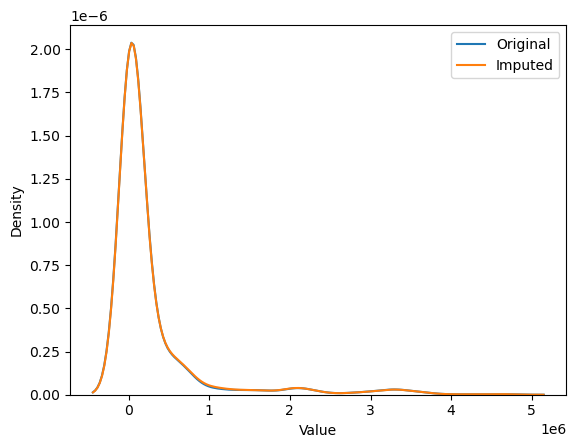

In [17]:
# Plot the KDE of 'Value' in the original data
sns.kdeplot(funnel['Value'], label='Original')
# Plot the KDE of 'Value' in the complete data
sns.kdeplot(complete_data['Value'], label='Imputed')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [18]:
funnel=complete_data

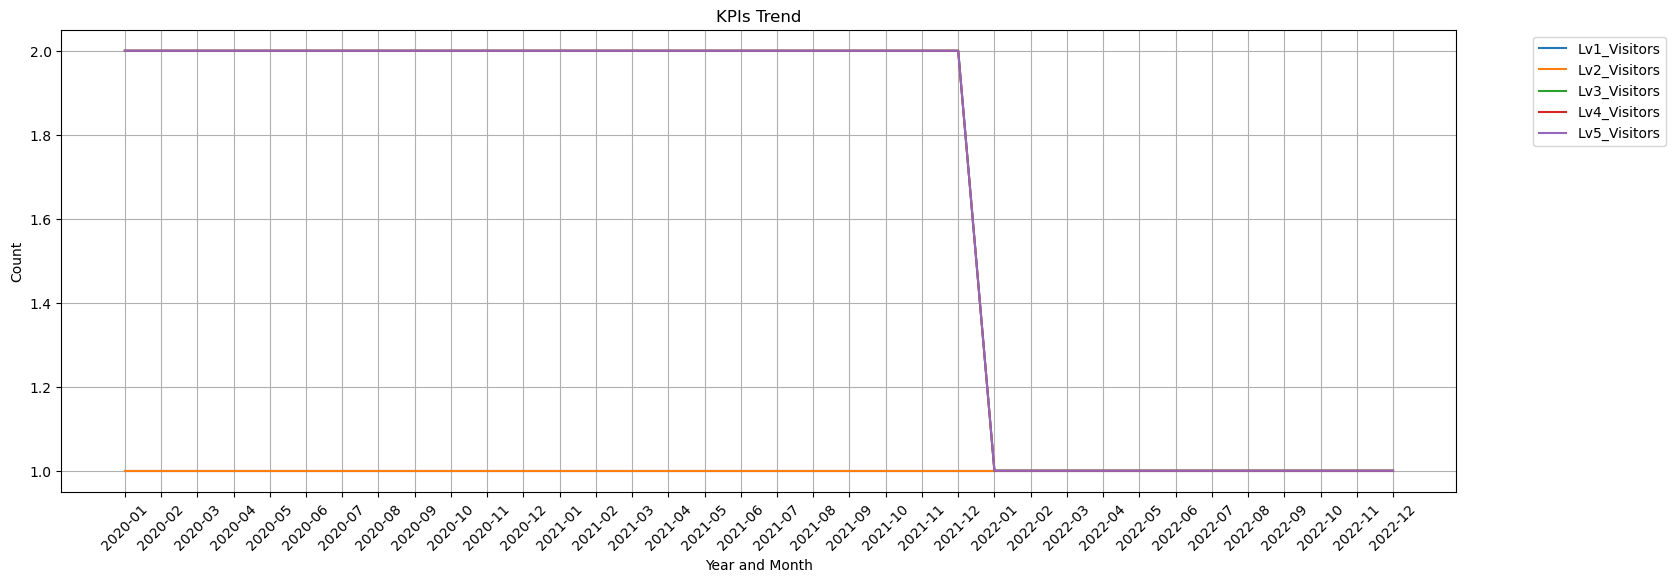

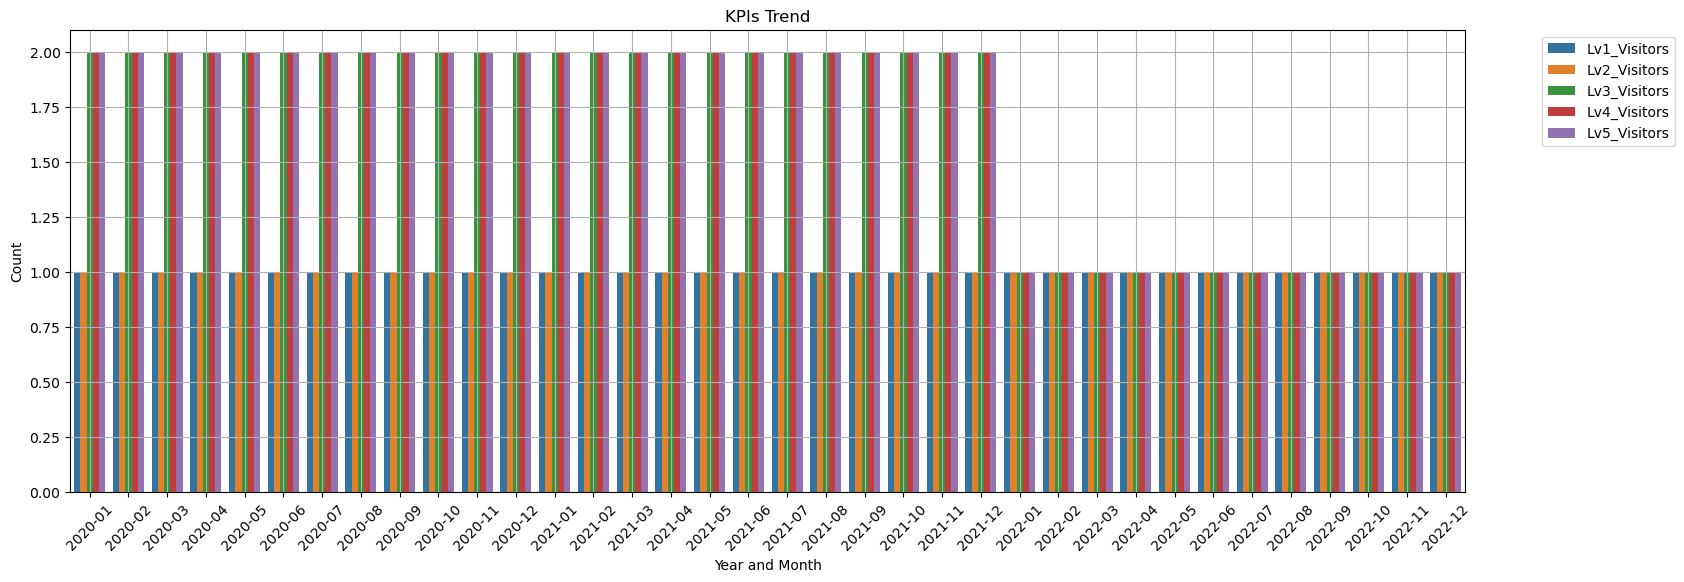

In [19]:
def plot_kpi_trends(data, region, customer_segment, start_year, start_month, end_year, end_month):
    # Filter the data based on the input parameters
    filtered_data = data[(data['Region'] == region) & 
                         (data['Customer Segment'] == customer_segment) & 
                         (data['Year'] >= start_year) & 
                         (data['Year'] <= end_year) & 
                         (data['Month'] >= start_month) & 
                         (data['Month'] <= end_month)]
    
    # Create a new column for year and month
    filtered_data['YearMonth'] = pd.to_datetime(filtered_data[['Year', 'Month']].assign(day=1))
    
    # Convert 'YearMonth' to string type
    filtered_data['YearMonth'] = filtered_data['YearMonth'].dt.strftime('%Y-%m')
    
    # Aggregate the data by 'YearMonth' and 'KPI'
    aggregated_data = filtered_data.groupby(['YearMonth', 'KPI']).size().reset_index(name='Count')

    # Sort 'YearMonth'
    aggregated_data.sort_values('YearMonth', inplace=True)

    # Determine figure size
    num_dates = aggregated_data['YearMonth'].nunique()
    fig_width = max(10, num_dates // 2)

    # Plot line graph
    plt.figure(figsize=(fig_width, 6))
    sns.lineplot(x='YearMonth', y='Count', hue='KPI', data=aggregated_data)
    plt.title('KPIs Trend')
    plt.xlabel('Year and Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Plot bar graph
    plt.figure(figsize=(fig_width, 6))
    sns.barplot(x='YearMonth', y='Count', hue='KPI', data=aggregated_data)
    plt.title('KPIs Trend')
    plt.xlabel('Year and Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function with your parameters
plot_kpi_trends(funnel, 'India', 'Clients', 2020, 1, 2022, 12)

In [19]:
# Initialize label encoders
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()

# Fit and transform 'Customer Segment' and 'Region' columns
funnel['Customer Segment'] = le1.fit_transform(funnel['Customer Segment'])
funnel['Region'] = le2.fit_transform(funnel['Region'])
funnel['KPI'] = le3.fit_transform(funnel['KPI'])

In [20]:
data = funnel['Value']

# Determine the length of the training data set (80% of total data)
train_len = int(len(data) * 0.8)

# Split the data into training and testing sets
train_data = data[:train_len]
test_data = data[train_len:]

# SARIMA

In [23]:
already_done=True
if not already_done:    
    # Define the grid
    param_grid = {'p': list(range(0, 5)), 'd': list(range(0, 3)), 'q': list(range(0, 5)),
                'P': list(range(0, 3)), 'D': list(range(0, 2)), 'Q': list(range(0, 3)), 'm': [1,6,12]}


    # Number of iterations for random search
    n_iter = 100

    best_score, best_params = float("inf"), None

    # Random search
    for i in range(n_iter):
        params = {k: sample(v, 1)[0] for k, v in param_grid.items()}
        try:
            # Train and evaluate SARIMA model
            model = SARIMAX(train_data, order=(params['p'], params['d'], params['q']),
                            seasonal_order=(params['P'], params['D'], params['Q'], params['m']))
            model_fit = model.fit(disp=False)
            mse = mean_squared_error(test_data, model_fit.predict(len(train_data), len(data)-1))
            
            # Update best score and parameters
            if mse < best_score:
                best_score, best_params = mse, params
                
        except:
            continue
        
        print(f"Iteration {i+1}: Best MSE: {best_score}, Best Params: {best_params}")

    print('Best MSE: ', best_score)
    print('Best Parameters: ', best_params)


In [24]:
# Fit the SARIMAX model on the training data
model = SARIMAX(train_data, order=(0, 0, 4), seasonal_order=(2, 1, 2, 6)) #Best Params
model_fit = model.fit(disp=True)

# Make predictions for the length of the test data
forecast = model_fit.predict(len(train_data), len(data)-1)

# Calculate MSE
mse = mean_squared_error(test_data, forecast)

# Calculate RMSE
rmse = mse**0.5

print('MSE: ', mse)
print('RMSE: ', rmse)

MSE:  314961575259.3641
RMSE:  561214.3754924352


<Axes: xlabel='date', ylabel='Value'>

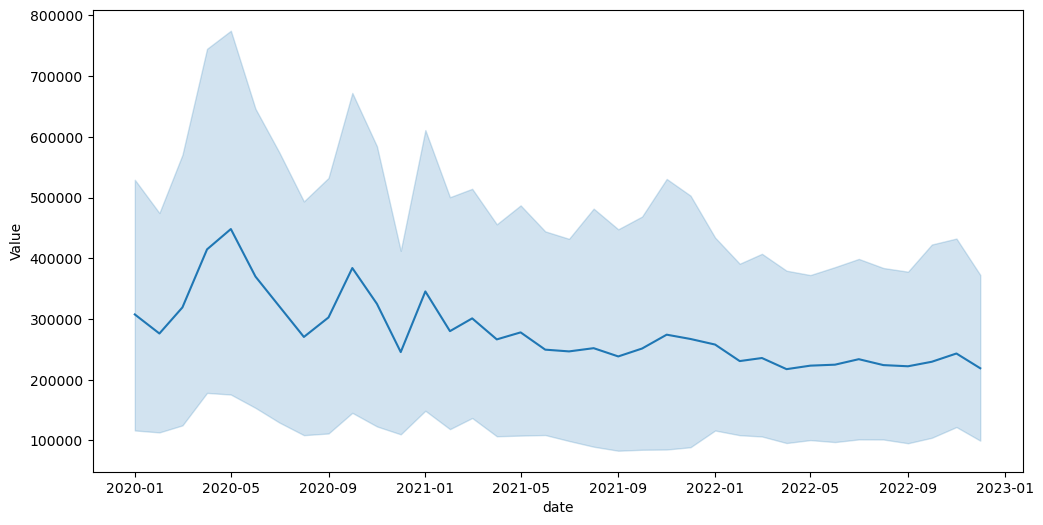

In [68]:
df=funnel[["Value","date"]]
plt.figure(figsize=(12,6))
df.set_index('date', inplace=True)
sns.lineplot(data=df,x="date",y='Value')

In [38]:
data = funnel['Value']

# Fit the SARIMAX model on the entire data
model = SARIMAX(data, order=(0, 0, 4), seasonal_order=( 2, 1, 2, 6)) #Best Params
model_fit = model.fit(disp=True)

# Make predictions for the entire data
forecast = model_fit.predict(start=0, end=len(data)-1)

# Save the actual and forecasted values to a CSV file
df = pd.DataFrame({
    'Actual': data,
    'Forecast': forecast})
df.to_csv('sarima_forecast.csv', index=False)

print('RMSE: ', mean_squared_error(data, forecast)**0.5)

RMSE:  600284.924047019


In [69]:
# Define a function to evaluate a SARIMA model
def evaluate_sarima_model(data):
    order = (0, 0, 4)
    seasonal_order = ( 2, 1, 2, 6)
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.predict(len(data), len(data)+len(test_data)-1)
    mse = mean_squared_error(test_data, forecast)
    return mse


# Evaluate the original model
original_mse = evaluate_sarima_model(train_data)
print(f'Original RMSE: {original_mse**0.5}')

# Apply transformations and steps

# 1. Detrending/Stationarity: Apply differencing to make the data stationary
diff_train_data = train_data.diff().dropna()
diff_mse = evaluate_sarima_model(diff_train_data)
print(f'Differenced RMSE: {diff_mse**0.5}')

# 2. Anomaly detection: Remove outliers
trimmed_train_data = train_data[train_data.between(train_data.quantile(.15), train_data.quantile(.85))]
trimmed_mse = evaluate_sarima_model(trimmed_train_data)
print(f'Trimmed RMSE: {trimmed_mse**0.5}')

# 3. Missing data: Fill missing values with the mean
filled_train_data = train_data.fillna(train_data.mean())
filled_mse = evaluate_sarima_model(filled_train_data)
print(f'Filled RMSE: {filled_mse**0.5}')

def evaluate_sarima_model(data, exog_data):
    order = (0, 0, 4)
    seasonal_order = (2, 1, 2, 6)
    model = SARIMAX(data, exog=exog_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.predict(len(data), len(data)+len(test_data)-1, exog=exog_test_data)
    mse = mean_squared_error(test_data, forecast)
    return mse


# Define your exogenous variables based on their correlation with 'Value'
exog_train_data = funnel[:train_len][['Customer Segment', 'Region']]
exog_test_data = funnel[train_len:][['Customer Segment', 'Region']]

# Evaluate the SARIMA model with exogenous variables
exog_mse = evaluate_sarima_model(funnel[:train_len]['Value'], exog_train_data)
print(f'Exogenous RMSE: {exog_mse**0.5}')

Original RMSE: 561214.3754924352
Differenced RMSE: 613173.7996174919
Trimmed RMSE: 579070.8810399765
Filled RMSE: 561214.3754924352
Exogenous RMSE: 553422.9952106327


In [82]:
result = adfuller(funnel["Value"])
print('ADF Statistic: %f' % result[0])
print('p-value: %.150f' % result[1])

ADF Statistic: -18.172169
p-value: 0.000000000000000000000000000002445384283289958406341440474605533964716996128310465351930108884151316723958079300121903898457276227418333292007446289062


MSE: 255664550448.78214
RMSE: 505632.8217677153


Text(0.5, 1.0, 'Autocorrelations of residuals')

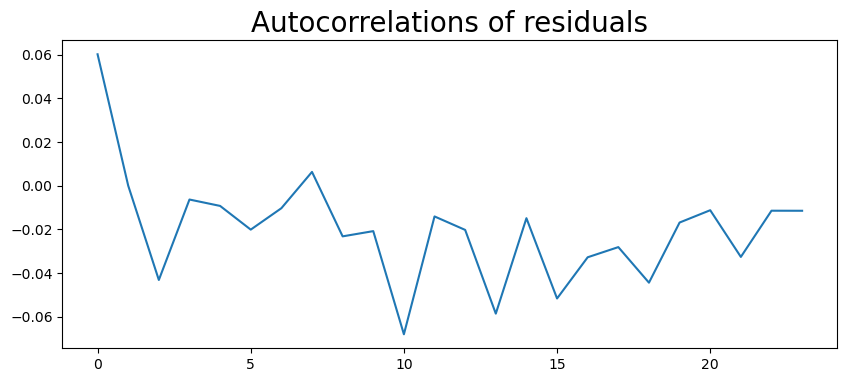

In [83]:
# Fit the model
model_fit = model.fit(disp=False)

# Get the forecast
forecast = model_fit.predict(len(train_data), len(train_data)+len(test_data)-1)

# Calculate residuals
residuals = test_data - forecast

# Print MSE and RMSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot ACF of residuals
acf_values = acf(residuals)
plt.figure(figsize=(10,4))
plt.plot(acf_values[1:])
plt.title('Autocorrelations of residuals', fontsize=20)


# LSTM

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Assume df is your DataFrame and you want to predict the 'Value' column
values = funnel['Value'].values
values = values.astype('float32').reshape(-1, 1)

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)
values

array([[0.7064497 , 0.00611612],
       [0.00611612, 0.00902173],
       [0.00902173, 0.01022089],
       ...,
       [0.00248752, 0.00158388],
       [0.00158388, 0.00248075],
       [0.00248075, 0.00231703]], dtype=float32)

In [22]:
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(1256, 1, 1) (1256,) (315, 1, 1) (315,)


In [25]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1256/1256 [==============================] - 5s 3ms/step - loss: 0.0564 - val_loss: 0.0451
Epoch 2/50
1256/1256 [==============================] - 3s 2ms/step - loss: 0.0547 - val_loss: 0.0443
Epoch 3/50
1256/1256 [==============================] - 3s 2ms/step - loss: 0.0540 - val_loss: 0.0435
Epoch 4/50
1256/1256 [==============================] - 3s 2ms/step - loss: 0.0538 - val_loss: 0.0443
Epoch 5/50
1256/1256 [================

In [27]:
model.save('LSTM.h5')

In [49]:
model=load_model('LSTM.h5')
yhat = model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)

mae = mean_absolute_error(test_y, inv_yhat)
mse = mean_squared_error(test_y, inv_yhat)
rmse = mse**0.5

print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

10/10 [==============================] - 0s 2ms/step
Test MAE: 132611.375
Test MSE: 47997505536.000
Test RMSE: 219083.330


In [61]:
a=values[:,:-1]
a=a.reshape((a.shape[0], 1, a.shape[1]))
scaler.inverse_transform(model.predict(a))

50/50 [==============================] - 0s 2ms/step


array([[367570.66 ],
       [ 36679.35 ],
       [ 49667.46 ],
       ...,
       [ 20241.854],
       [ 16110.764],
       [ 20210.92 ]], dtype=float32)

In [65]:
data = funnel['Value']

df = pd.DataFrame({
    'Actual': data[1:],
    'Forecast': scaler.inverse_transform(model.predict(a)).flatten()})

df.to_csv('lstm_forecast.csv', index=False)

50/50 [==============================] - 0s 2ms/step
